# Explore road network speed limits

- Explore speed limits and restrictions
- Split into speed limit classes
- Generate statistics
- Compare speed limit classes

In [3]:
import requests
import sys
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

crs = 25832
country_iso = 'DE'

sns.set_theme(style="ticks")
sns.set_context("paper")

data_dir = Path('../data')
out_dir = Path('../outdir')

In [4]:
road_network = gpd.read_feather(out_dir / 'preprocessed_road_network.feather')

## Explore speed values

In [5]:
road_network.columns

Index(['geometry', 'highway', 'maxspeed', 'maxspeed:conditional',
       'maxspeed:reason', 'maxspeed:type', 'motorroad', 'source:maxspeed',
       'temporary:maxspeed', 'zone:maxspeed', 'zone:traffic'],
      dtype='object')

Check for any lists in the road network

In [6]:
any(road_network.applymap(lambda x: isinstance(x, list)).any())

/tmp/ipykernel_1590/2737975753.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  any(road_network.applymap(lambda x: isinstance(x, list)).any())


False

In [7]:
total_count = road_network.shape[0]
round((road_network['maxspeed'].value_counts(dropna=False) / total_count) * 100, 2)

maxspeed
None        76.34
30          11.92
50           6.93
70           1.66
100          0.90
10           0.48
20           0.40
120          0.40
none         0.32
walk         0.23
7            0.14
60           0.09
15           0.06
80           0.04
5            0.02
130          0.01
40           0.01
90           0.01
6            0.01
32           0.01
8            0.00
25           0.00
variable     0.00
DE:urban     0.00
DE:walk      0.00
Name: count, dtype: float64

In [8]:
road_network['maxspeed'].value_counts(dropna=False).sort_values(ascending=False)

maxspeed
None        102871
30           16065
50            9341
70            2234
100           1209
10             641
20             544
120            533
none           437
walk           316
7              195
60             121
15              80
80              59
5               24
130             19
40              16
90              13
6               12
32               9
8                5
25               5
variable         3
DE:urban         1
DE:walk          1
Name: count, dtype: int64

Remove all occurences of 'sign' (no meaning)

In [9]:
road_network = road_network.replace('sign', np.nan)

Get unique combinations of values and save as csv

In [10]:
speed_cols_list = ['maxspeed', 'maxspeed:type', 'source:maxspeed', 'zone:maxspeed', 'zone:traffic']

In [11]:
road_network[speed_cols_list].value_counts(dropna=False).sort_values(ascending=False).reset_index().to_csv(out_dir / 'road_network_speeds_col.csv')

Count how many missing maxspeed values can be filled with speed cols

In [12]:
road_network.loc[road_network['maxspeed'].isna(), speed_cols_list].notna().any(axis=1).sum()

528

## Preprocess speed limit values

In [4]:
preprocessed_road_network = road_network.copy()

Query car speed values from ORS

In [49]:
r = requests.get(
    r'https://raw.githubusercontent.com/GIScience/openrouteservice/master/ors-engine/src/main/resources/resources/services/routing/speed_limits/car.json'
)
if r.status_code == 200:  # Status == OK
    hwy_speeds = r.json()
else:
    print(f'Error when requesting ORS for speed limits: {r.status_code}')
    sys.exit()

Replace 'walk' in maxspeed with walking-speed in Germany

In [50]:
walk_speed = hwy_speeds['max_speeds'][f'{country_iso}:living_street']
preprocessed_road_network['maxspeed'] = preprocessed_road_network['maxspeed'].replace(['walk', f'{country_iso}:walk'], walk_speed)

Replace f'{country_iso}:urban' in maxspeed with urban speed limit in Germany

In [51]:
urban_speed = hwy_speeds['max_speeds'][f'{country_iso}:urban']
preprocessed_road_network['maxspeed'] = preprocessed_road_network['maxspeed'].replace(f'{country_iso}:urban', urban_speed)

Replace 'variable' in maxspeed with None

In [52]:
preprocessed_road_network['maxspeed'] = preprocessed_road_network['maxspeed'].replace('variable', None)

Replace 'default' in maxspeed with according maxspeed from route type

In [53]:
preprocessed_road_network['maxspeed'] = preprocessed_road_network.apply(
    lambda row: hwy_speeds['default'][row['highway']] if row['maxspeed'] == 'default' else row['maxspeed'], 
    axis=1
)

Replace 'none' (value) in maxspeed with 255 to show unlimited speed limit

In [54]:
max_speed = pd.to_numeric(preprocessed_road_network['maxspeed'], errors='coerce').max().astype(int)
preprocessed_road_network['maxspeed'] = preprocessed_road_network['maxspeed'].replace('none', 255) # none (str) != None (Nan)

Checkpoint v1

In [55]:
preprocessed_road_network[speed_cols_list].value_counts(dropna=False).sort_values(ascending=False).reset_index().to_csv(out_dir / 'preprocessed_road_network_speeds_v1.csv')

### Missing value imputation (manual)

Step 1: Merge 'zone:traffic' to 'zone:maxspeed'

In [56]:
if 'zone:maxspeed' not in preprocessed_road_network.columns:
    preprocessed_road_network['zone:maxspeed'] = np.nan

In [57]:
if 'zone:traffic' in preprocessed_road_network.columns:
    preprocessed_road_network['zone:maxspeed'] = preprocessed_road_network['zone:maxspeed'].fillna(preprocessed_road_network['zone:traffic'])

In [58]:
preprocessed_road_network['zone:maxspeed'].value_counts()

DE:urban        1064
DE:rural         473
DE:30            362
DE:motorway      124
urban             62
20                11
DE:motorroad      11
30                 9
rural              6
DE:10              3
DE:20              2
DE.rural           1
Name: zone:maxspeed, dtype: int64

Step 2: Merge 'zone:maxspeed' to 'source:maxspeed'

In [59]:
if 'source:maxspeed' not in preprocessed_road_network.columns:
    preprocessed_road_network['source:maxspeed'] = np.nan

In [60]:
if 'zone:maxspeed' in preprocessed_road_network.columns:
    preprocessed_road_network['source:maxspeed'] = preprocessed_road_network['source:maxspeed'].fillna(preprocessed_road_network['zone:maxspeed'])

In [61]:
preprocessed_road_network['source:maxspeed'].value_counts()

DE:urban                                          3446
DE:zone30                                         1795
DE:rural                                           811
DE:motorway                                        453
DE:zone:30                                         393
DE:30                                              347
DE:zone                                            253
DE:bicycle_road                                     57
urban                                               49
DE:zone:20                                          12
DE:motorroad                                        11
30                                                   9
www.openstreetmap.org/browse/changeset/8913447       8
20                                                   8
DE:zone20                                            7
implicit                                             5
zone                                                 5
DE:zone10                                            5
DE:living_

Step 3: Merge 'maxspeed:type' to 'source:maxspeed'

In [62]:
if 'maxspeed:type' in preprocessed_road_network.columns:
    preprocessed_road_network['source:maxspeed'] = preprocessed_road_network['source:maxspeed'].fillna(preprocessed_road_network['maxspeed:type'])

In [63]:
preprocessed_road_network['source:maxspeed'].value_counts()

DE:urban                                          3830
DE:zone30                                         2430
DE:rural                                           871
DE:motorway                                        453
DE:zone:30                                         393
DE:zone                                            377
DE:30                                              347
DE:bicycle_road                                     57
urban                                               49
DE:zone20                                           22
DE:zone:20                                          12
DE:motorroad                                        11
DE:zone50                                           10
30                                                   9
www.openstreetmap.org/browse/changeset/8913447       8
20                                                   8
DE:zone10                                            8
implicit                                             5
zone      

Checkpoint v2

In [64]:
preprocessed_road_network[speed_cols_list].value_counts(dropna=False).sort_values(ascending=False).reset_index().to_csv(out_dir / 'preprocessed_road_network_speeds_v2.csv')

### Fill maxspeed with filled source:maxspeed

In [65]:
preprocessed_road_network[preprocessed_road_network['maxspeed'].isna()]['source:maxspeed'].value_counts(dropna=False).sort_values()

20                  1
urban               2
DE:zone30           3
30                  3
DE:zone             4
DE:motorway         7
DE:rural          178
DE:urban          330
None           102346
Name: source:maxspeed, dtype: int64

In [66]:
urban_speed = hwy_speeds['max_speeds'][f'{country_iso}:urban']
rural_speed = hwy_speeds['max_speeds'][f'{country_iso}:rural']
motorway_speed = hwy_speeds['max_speeds'][f'{country_iso}:motorway']

Remove invalid zone values or extract numbers

In [67]:
preprocessed_road_network['source:maxspeed'] = preprocessed_road_network[preprocessed_road_network['maxspeed'].isna()]['source:maxspeed'].replace(f'{country_iso}:zone', None)
preprocessed_road_network['source:maxspeed'] = preprocessed_road_network['source:maxspeed'].str.replace('DE:zone', '')

Replace valid zone values

In [68]:
preprocessed_road_network['source:maxspeed'] = preprocessed_road_network[preprocessed_road_network['maxspeed'].isna()]['source:maxspeed'].replace(['urban', f'{country_iso}:urban'], urban_speed)
preprocessed_road_network['source:maxspeed'] = preprocessed_road_network[preprocessed_road_network['maxspeed'].isna()]['source:maxspeed'].replace(['rural', f'{country_iso}:rural'], rural_speed)
preprocessed_road_network['source:maxspeed'] = preprocessed_road_network[preprocessed_road_network['maxspeed'].isna()]['source:maxspeed'].replace(['motorway', f'{country_iso}:motorway'], motorway_speed)

In [69]:
preprocessed_road_network[preprocessed_road_network['maxspeed'].isna()]['source:maxspeed'].value_counts(dropna=False).sort_values()

20           1
30           6
130          7
100        178
50         332
None    102350
Name: source:maxspeed, dtype: int64

Fill empty maxspeed with values from filled and enriched source:maxspeed 

In [70]:
preprocessed_road_network['maxspeed'] = preprocessed_road_network['maxspeed'].fillna(preprocessed_road_network['source:maxspeed'])

Fill Nones with zeros 

In [71]:
preprocessed_road_network['maxspeed'] = preprocessed_road_network['maxspeed'].fillna(0)

Cast maxspeed col as int

In [72]:
preprocessed_road_network['maxspeed'] = preprocessed_road_network['maxspeed'].astype(int)

Checkpoint v3

In [73]:
preprocessed_road_network[speed_cols_list].value_counts(dropna=False).sort_values(ascending=False).reset_index().to_csv(out_dir / 'preprocessed_road_network_speeds_v3.csv')

### Speed limit assignment

In [75]:
preprocessed_road_network['maxspeed'].value_counts(dropna=False)

0      102350
30      16071
50       9674
70       2234
100      1387
10        641
20        545
120       533
7         512
255       437
60        121
15         80
80         59
130        26
5          24
40         16
90         13
6          12
32          9
8           5
25          5
Name: maxspeed, dtype: int64

Define classes 

In [76]:
speed_limits_dict = {
    'class_borders': [1, 10, 30, 50, 70, 90, 110, 130, 255],
    'class_labels': ['walk', 'very_low', 'low', 'medium', 'high', 'very_high', 'very_high+', 'unlimited']
}

Fill new col 'speed_limit_class'

In [77]:
preprocessed_road_network['speed_limit_class'] = pd.cut(
    preprocessed_road_network['maxspeed'],
    bins=speed_limits_dict['class_borders'],
    labels=speed_limits_dict['class_labels'],
    include_lowest=True
)

Add unknowns

In [78]:
preprocessed_road_network['speed_limit_class'] = preprocessed_road_network['speed_limit_class'].cat.add_categories('unknown')
preprocessed_road_network['speed_limit_class'] = preprocessed_road_network['speed_limit_class'].fillna('unknown')

In [79]:
preprocessed_road_network['speed_limit_class'].value_counts(dropna=False)

unknown       102350
very_low       16701
low             9699
medium          2355
very_high       1387
walk            1194
very_high+       559
unlimited        437
high              72
Name: speed_limit_class, dtype: int64

## Preprocessing speeds function

In [14]:
new_preprocess = road_network.copy()

In [15]:
new_preprocess['maxspeed'].value_counts(dropna=False)

maxspeed
None        102871
30           16065
50            9341
70            2234
100           1209
10             641
20             544
120            533
none           437
walk           316
7              195
60             121
15              80
80              59
5               24
130             19
40              16
90              13
6               12
32               9
8                5
25               5
variable         3
DE:urban         1
DE:walk          1
Name: count, dtype: int64

In [16]:
speed_cols = ['zone:maxspeed', 'zone:traffic', 'maxspeed:type', 'source:maxspeed', 'maxspeed']

speed_zone_types = ['living_street', 'urban', 'rural', 'trunk', 'motorway']

speed_limit_classes = {
    "class_bounds": [0, 1, 10, 30, 50, 70, 90, 110, 130, 255],
    "class_labels": ['unknown', 'walk', 'very_low', 'low', 'medium', 'high', 'very_high', 'very_high+', 'unlimited']
}

In [17]:
# Query OSM speed data
speeds_request = requests.get(
    r'https://raw.githubusercontent.com/GIScience/openrouteservice/master/ors-engine/src/main/resources/resources/services/routing/speed_limits/car.json'
)
if speeds_request.status_code == 200:  # Status == OK
    hwy_speeds = speeds_request.json()
    country_speeds = hwy_speeds['max_speeds']
    default_speeds = hwy_speeds['default']
else:
    print(f'Error when requesting ORS for speed limits: {speeds_request.status_code}')
    sys.exit()

# Create speed type mapping dictionary
speed_zone_types_mapping = {
    **{f'{key}': country_speeds.get(f'{country_iso}:{key}', default_speeds.get(key)) for key in speed_zone_types},
    'walk': country_speeds.get(f'{country_iso}:living_street', default_speeds.get('living_street')),
    'variable': np.nan,
    # none != Nan, so set to 255 as 'unlimited'
    'none': 255,
}

In [18]:
def feature_engineer_maxspeeds(road_network: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """This class method feature engineers the maxspeed column by applying manual MVI and casting to integers."""
    # Remove all occurrences of 'sign'
    road_network = road_network.replace('sign', np.nan, regex=False)

    # Enrich source:maxspeed by merging other columns
    for column in speed_cols:
        # Create col if it doesn't exist
        road_network[column] = road_network[column] if column in road_network.columns else np.nan
        # Add vales from col to source:maxspeed
        if road_network['source:maxspeed'].isna().any():
            road_network['source:maxspeed'] = road_network['source:maxspeed'].fillna(road_network[column])

    road_network = __cleanup_speed_column(road_network, 'source:maxspeed', speed_zone_types_mapping)
    road_network = __cleanup_speed_column(road_network, 'maxspeed', speed_zone_types_mapping)

    # Replace values in maxspeed with mapping_dict
    road_network['maxspeed'] = road_network['maxspeed'].replace(speed_zone_types_mapping)
    # Replace values in source:maxspeed only when maxspeed is Nan (if maxspeed exists, MVI not necessary)
    road_network.loc[road_network['maxspeed'].isna(), 'source:maxspeed'] = road_network['source:maxspeed'].replace(speed_zone_types_mapping)
    # Fill Nans in maxspeed with enriched source:maxspeed, fill remaining Nans with zeros
    road_network['maxspeed'] = road_network['maxspeed'].fillna(road_network['source:maxspeed']).fillna(0)

    def assign_maxspeeds_from_file(row):
        # Create adapted mapping dictionary using the speed file and highway type
        file_mapping_dict = {
            **{key: country_speeds.get(f'{country_iso}:{key}', default_speeds.get(row['highway'])) for key in speed_zone_types_mapping.keys()},
            # Check if highway type in default speeds, else set to 0
            'default': default_speeds.get(row['highway'], 0)
        }

        return file_mapping_dict.get(row['maxspeed'], row['maxspeed'])

    # Get speed values for speed type maxspeeds
    road_network['maxspeed'] = road_network.apply(assign_maxspeeds_from_file, axis=1)
    # Convert maxspeed values to integers
    road_network['maxspeed'] = road_network['maxspeed'].astype(int)

    # Return road network with feature engineered maxspeed, drop used cols except last one (maxspeed)
    return road_network.drop(columns=speed_cols[:-1], errors='ignore')

def categorize_speed_limits(road_network: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """This class method categorizes the speed limits of the road network."""
    road_network['speed_limit_class'] = (
        pd.cut(
            road_network['maxspeed'],
            bins=speed_limit_classes['class_bounds'],
            labels=speed_limit_classes['class_labels'],
            include_lowest=True,
            ordered=True
        )
    )
    # Drop all roads without assigned speed limit class
    road_network.dropna(subset=['speed_limit_class'], inplace=True)
    # Convert categorical col to strings (for OHE)
    road_network['speed_limit_class'] = road_network['speed_limit_class'].astype(str)

    return road_network


@staticmethod
def __cleanup_speed_column(df, column_name, mapping_dict):
    df[column_name] = (
        df[column_name]
        # Replace all points with colons (points are probably wrongly mapped)
        .str.replace('.', ':', regex=False)
        # Remove everything before and including a colon ':' (e.g. DE:zone30 -> zone30)
        .str.replace('^.*?:', '', regex=True)
        # Remove all occurrences of 'zone' (e.g. zone30 -> 30)
        .str.replace('zone', '', regex=False)
        # If remaining values are empty strings, convert them to Nan
        .replace('', np.nan)
    )
    # Check remains: if one of the conditions is True, keep value
    df[column_name] = df[column_name].where(
        # If value is Nan
        df[column_name].isna() |
        # If value is in speed_zone_types_mapping keys
        df[column_name].isin(mapping_dict.keys()) |
        # If value is a digit
        df[column_name].str.isdigit() |
        # Default values get assigned later on (special case)
        (df[column_name] == 'default')
    )
    return df

In [19]:
country_iso = 'DE'
new_preprocess = feature_engineer_maxspeeds(new_preprocess)
new_preprocess = categorize_speed_limits(new_preprocess)

In [20]:
new_preprocess.to_crs(epsg=25832, inplace=True)
# Calculate the length of each feature
new_preprocess['road_length'] = new_preprocess['geometry'].length / 1000

# Calculate total length for each speed_limit_class
total_length_per_speed = new_preprocess.groupby('speed_limit_class')['road_length'].sum()

total_length_per_speed.sort_values(ascending=False)
print(round(total_length_per_speed, 2))

# Calculate total length
total_length = total_length_per_speed.sum()
print('Total length:', round(total_length, 2))

# Calculate the proportion of each 'highway' type
proportion_per_speed = round((total_length_per_speed / total_length) * 100, 2)

# Sort the result
proportion_per_speed.sort_values(ascending=False)

speed_limit_class
high             18.49
low             837.10
medium          265.73
unknown       13374.75
unlimited       132.73
very_high       361.76
very_high+      136.70
very_low       2376.67
walk            102.65
Name: road_length, dtype: float64
Total length: 17606.58


speed_limit_class
unknown       75.96
very_low      13.50
low            4.75
very_high      2.05
medium         1.51
very_high+     0.78
unlimited      0.75
walk           0.58
high           0.10
Name: road_length, dtype: float64

In [21]:
new_preprocess_ex = new_preprocess.copy()
new_preprocess_ex = new_preprocess_ex[new_preprocess_ex['speed_limit_class'] != 'unknown']
# Calculate the length of each feature
new_preprocess_ex['road_length'] = new_preprocess_ex['geometry'].length / 1000

# Calculate total length for each speed_limit_class
total_length_per_speed = new_preprocess_ex.groupby('speed_limit_class')['road_length'].sum()
print(round(total_length_per_speed, 2))

# Calculate total length
total_length = total_length_per_speed.sum()
print('Total length:', round(total_length, 2))

# Calculate the proportion of each 'highway' type
proportion_per_speed = round((total_length_per_speed / total_length) * 100, 2)

# Sort the result
proportion_per_speed.sort_values(ascending=False)

speed_limit_class
high            18.49
low            837.10
medium         265.73
unlimited      132.73
very_high      361.76
very_high+     136.70
very_low      2376.67
walk           102.65
Name: road_length, dtype: float64
Total length: 4231.83


speed_limit_class
very_low      56.16
low           19.78
very_high      8.55
medium         6.28
very_high+     3.23
unlimited      3.14
walk           2.43
high           0.44
Name: road_length, dtype: float64

speed_limit_class
unknown       102350
very_low       16701
low             9699
medium          2355
very_high       1387
walk            1194
very_high+       559
unlimited        437
high              72
Name: count, dtype: int64


<Figure size 1000x1000 with 0 Axes>

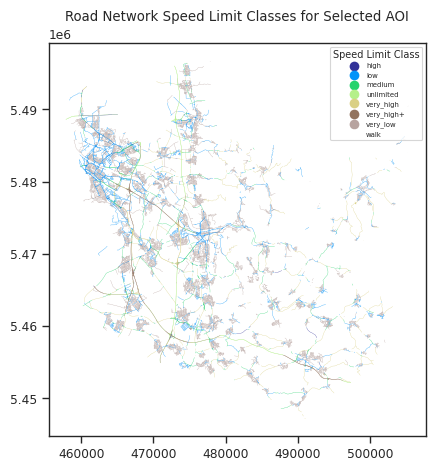

In [25]:
print(new_preprocess['speed_limit_class'].value_counts(dropna=False))

plt.figure(figsize=(10, 10))

new_preprocess[new_preprocess['speed_limit_class'] != 'unknown'].plot(
    column='speed_limit_class', 
    cmap='terrain', 
    linewidth=0.2, 
    legend=True, 
    legend_kwds={'loc': 'upper right', 'title': 'Speed Limit Class', 'title_fontsize': 7, 'fontsize': 5, 'markerscale': 0.7}
)
plt.title('Road Network Speed Limit Classes for Selected AOI')

plt.savefig(out_dir / 'road_network_speeds.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [23]:
new_preprocess.to_feather(out_dir / 'preprocessed_speed_limit_classes.feather')